## IMPORTS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from penaltyblog.matchflow import Flow, where_equals

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='statsbombpy')

In [2]:
MATCH_ID = 22912

print(f"Loading all events for match ID: {MATCH_ID}...")

flow = Flow.statsbomb.events(MATCH_ID)

# Collect the data into a list first
event_list = flow.collect()

df_events = pd.DataFrame(event_list)

print(f"\nSuccessfully loaded and converted {len(df_events):,} events for the match.")
print("Here are the first few events:")

display(df_events.head())

Loading all events for match ID: 22912...

Successfully loaded and converted 3,165 events for the match.
Here are the first few events:


,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,clearance,foul_won,interception,ball_recovery,counterpress,out,dribble,50_50,substitution,block
0,9ec3d009-c15b-4a8d-be80-57a07f40755a,1,1,00:00:00.000,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 38, 'name': 'Tottenham Hotspur'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e8bdb5d1-8bcb-4a0d-bfd2-68c18c7f54d0,2,1,00:00:00.000,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 38, 'name': 'Tottenham Hotspur'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00b678a4-3767-4d0b-92e6-9cb4c959d94d,3,1,00:00:00.000,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 38, 'name': 'Tottenham Hotspur'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,05840f64-0fb7-4f2d-885a-49790d6bd4df,4,1,00:00:00.000,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 38, 'name': 'Tottenham Hotspur'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,b67ef6a9-e877-4dbe-bb03-edcc9d8c7711,5,1,00:00:00.208,0,0,"{'id': 30, 'name': 'Pass'}",2,"{'id': 24, 'name': 'Liverpool'}","{'id': 9, 'name': 'From Kick Off'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


3: Basic Data Exploration

In [3]:
if 'df_events' in locals():
    # Print the shape of the DataFrame
    print(f"The DataFrame has {df_events.shape[0]} rows (events) and {df_events.shape[1]} columns (attributes).")

    # Let's see all available columns to find the right one
    print("\nAvailable columns:")
    print(df_events.columns.tolist())

    print("\nThe following event types were recorded in this match:")
    event_types = df_events['type'].apply(lambda x: x['name']).unique()
    display(event_types)
    
else:
    print("Event DataFrame not found. Please run the cell above first.")

The DataFrame has 3165 rows (events) and 37 columns (attributes).

Available columns:
['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type', 'possession', 'possession_team', 'play_pattern', 'team', 'duration', 'tactics', 'match_id', 'related_events', 'player', 'position', 'location', 'pass', 'carry', 'ball_receipt', 'under_pressure', 'duel', 'foul_committed', 'shot', 'goalkeeper', 'off_camera', 'clearance', 'foul_won', 'interception', 'ball_recovery', 'counterpress', 'out', 'dribble', '50_50', 'substitution', 'block']

The following event types were recorded in this match:


array(['Starting XI', 'Half Start', 'Pass', 'Ball Receipt*', 'Carry',
       'Duel', 'Pressure', 'Foul Committed', 'Shot', 'Goal Keeper',
       'Clearance', 'Ball Recovery', 'Foul Won', 'Interception',
       'Miscontrol', 'Dispossessed', 'Dribbled Past', 'Dribble', '50/50',
       'Block', 'Shield', 'Injury Stoppage', 'Referee Ball-Drop',
       'Half End', 'Substitution', 'Tactical Shift', 'Offside'],
      dtype=object)

4: Count Events by Player 

In [4]:
if 'flow' in locals():
    print("Counting the total number of on-ball events for each player...")

    events_by_player = (
        flow.group_by("player.name")
        .summary({"total_events": ("count", "id")})
        
        .sort_by("total_events", ascending=False)
        .rename(**{"player.name": "player"})
        .collect()
    )

    df_player_events = pd.DataFrame(events_by_player)

    print("\n--- Most Active Players (by Total Events) ---")
    display(df_player_events.head(10))

else:
    print("Matchflow object 'flow' not found. Please load the match data first.")

Counting the total number of on-ball events for each player...

--- Most Active Players (by Total Events) ---


,total_events,player
0,229,Jan Vertonghen
1,213,Toby Alderweireld
2,181,Kieran Trippier
3,165,Hugo Lloris
4,156,Christian Dannemann Eriksen
5,153,Bamidele Alli
6,153,Danny Rose
7,147,Harry Winks
8,142,Heung-Min Son
9,140,Sadio Mané


5: Install mplsoccer and Prepare Pass Data

In [7]:
from penaltyblog.matchflow import get_field

LIVERPOOL_TEAM_NAME = "Liverpool"

print(f"Filtering for all completed passes by {LIVERPOOL_TEAM_NAME}...")

liverpool_passes = (
    flow.filter(where_equals("team.name", LIVERPOOL_TEAM_NAME))
    .filter(where_equals("type.name", "Pass"))
    .filter(lambda r: get_field(r, "pass.outcome.name") is None)
    
    # --- FIX: Use .split_array() to correctly extract coordinates ---
    .split_array("location", ["start_x", "start_y"])
    .split_array("pass.end_location", ["end_x", "end_y"])
    
    .select(
        "player.name", 
        "pass.recipient.name", 
        "start_x", 
        "start_y", 
        "end_x", 
        "end_y"
    )
    .collect()
)

df_liverpool_passes = pd.DataFrame(liverpool_passes)


if not df_liverpool_passes.empty:
    print(f"\nFound and processed {len(df_liverpool_passes)} completed passes.")
    display(df_liverpool_passes.head())
else:
    print("\nNo completed passes found for Liverpool.")

Filtering for all completed passes by Liverpool...

Found and processed 202 completed passes.


,player,pass,start_x,start_y,end_x,end_y
0,{'name': 'Jordan Brian Henderson'},{'recipient': {'name': 'Joël Andre Job Matip'}},61.0,40.1,34.0,43.8
1,{'name': 'Virgil van Dijk'},{'recipient': {'name': 'Georginio Wijnaldum'}},59.5,19.6,65.4,19.2
2,{'name': 'Georginio Wijnaldum'},{'recipient': {'name': 'Jordan Brian Henderson'}},64.7,18.4,64.9,23.8
3,{'name': 'Jordan Brian Henderson'},{'recipient': {'name': 'Sadio Mané'}},64.3,24.3,99.2,24.5
4,{'name': 'Andrew Robertson'},{'recipient': {'name': 'Sadio Mané'}},43.7,0.1,53.6,8.5


6: Calculate Average Player Positions

In [9]:
if 'flow' in locals():
    print(f"Calculating the average on-pitch location for each {LIVERPOOL_TEAM_NAME} player...")

    # We filter for Liverpool events, split the location array, group by player, and find the mean location
    player_locations = (
        flow.filter(where_equals("team.name", LIVERPOOL_TEAM_NAME))
        .filter(lambda r: get_field(r, "location") is not None) 
        .split_array("location", ["x", "y"])
        .group_by("player.name")
        .summary({"avg_x": ("mean", "x"), "avg_y": ("mean", "y")})
        .rename(**{"player.name": "player"})
        .collect()
    )

    # Convert to a DataFrame
    df_player_locations = pd.DataFrame(player_locations)

    print("\n--- Average Player Positions ---")
    display(df_player_locations)

else:
    print("Matchflow object 'flow' not found. Please load the match data first.")

Calculating the average on-pitch location for each Liverpool player...

--- Average Player Positions ---


,avg_x,avg_y,player
0,64.910744,54.105785,Jordan Brian Henderson
1,31.391209,54.101099,Joël Andre Job Matip
2,77.589209,22.246763,Sadio Mané
3,52.390323,41.867742,Fábio Henrique Tavares
4,77.695652,37.211957,Roberto Firmino Barbosa de Oliveira
5,35.614130,31.170652,Virgil van Dijk
6,64.644615,27.747692,Georginio Wijnaldum
7,88.010870,54.762319,Mohamed Salah
8,50.833571,11.250714,Andrew Robertson
9,53.671795,63.534188,Trent Alexander-Arnold


7: Plot the Team Pass Map

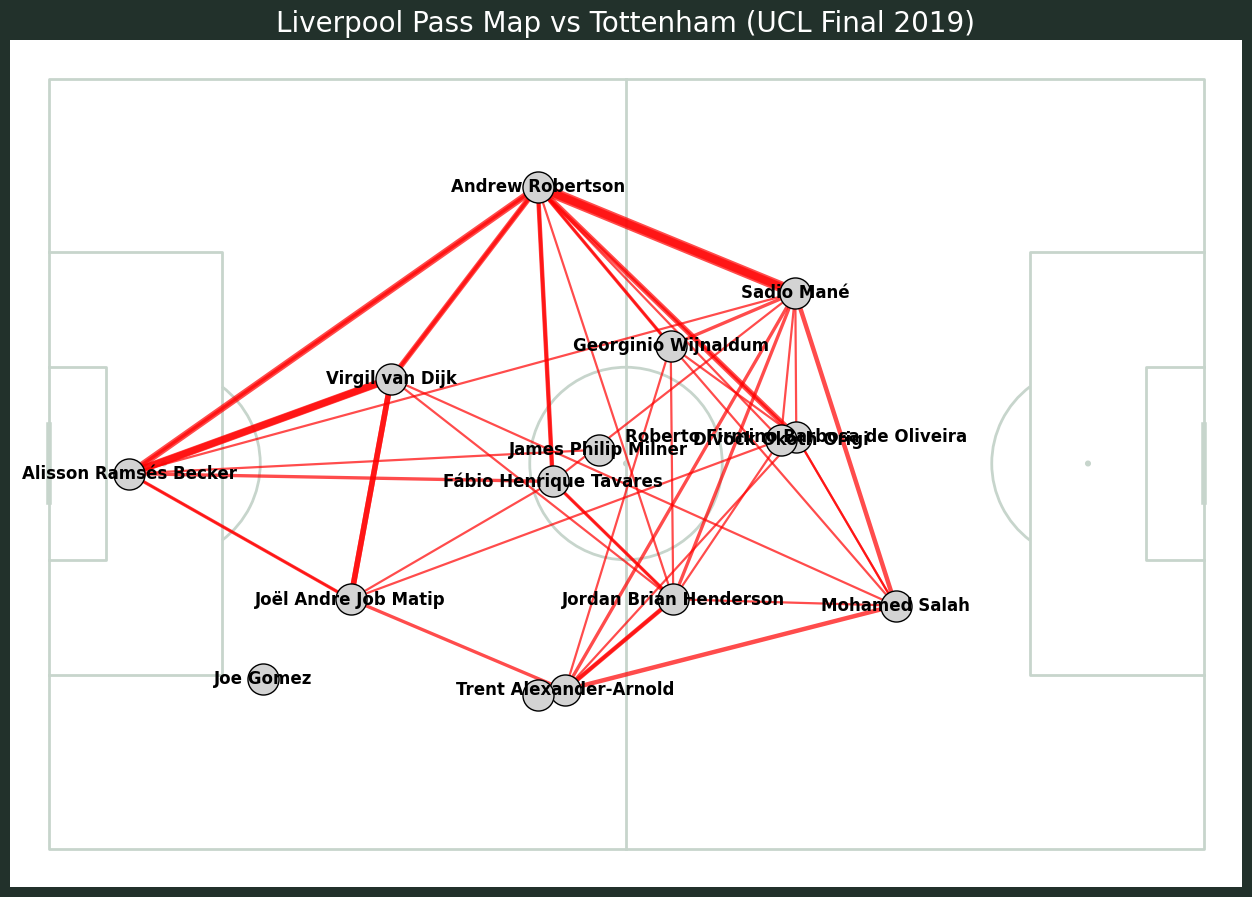

In [23]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Prepare the data (No changes needed) ---
df_liverpool_passes['passer'] = df_liverpool_passes['player'].apply(
    lambda x: x.get('name') if isinstance(x, dict) else None
)
df_liverpool_passes['recipient'] = df_liverpool_passes['pass'].apply(
    lambda x: x.get('recipient', {}).get('name') if isinstance(x, dict) else None
)
df_liverpool_passes.dropna(subset=['passer', 'recipient'], inplace=True)
df_pass_counts = df_liverpool_passes.groupby(['passer', 'recipient']).size().reset_index(name='pass_count')
df_pass_counts = pd.merge(df_pass_counts, df_player_locations, left_on='passer', right_on='player', how='inner')
df_pass_counts = pd.merge(df_pass_counts, df_player_locations, left_on='recipient', right_on='player', how='inner', suffixes=('_start', '_end'))


# --- 2. Create the plot ---
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor("#22312b")

MIN_PASS_COUNT = 2 
for _, row in df_pass_counts[df_pass_counts['pass_count'] >= MIN_PASS_COUNT].iterrows():
    pitch.lines(
        xstart=row['avg_x_start'], ystart=row['avg_y_start'],
        xend=row['avg_x_end'], yend=row['avg_y_end'],
        lw=row['pass_count'] * 0.8, color='#FF0000', zorder=2, ax=ax, alpha=0.7
    )

pitch.scatter(df_player_locations.avg_x, df_player_locations.avg_y, s=500, color='#d3d3d3', edgecolors='black', zorder=3, ax=ax)
for _, row in df_player_locations.iterrows():
    pitch.annotate(row['player'], xy=(row['avg_x'], row['avg_y']), c='black', va='center', ha='center', size=12, ax=ax, zorder=4, weight='bold')

ax.set_title(f"{LIVERPOOL_TEAM_NAME} Pass Map vs Tottenham (UCL Final 2019)", color="white", size=20)
plt.show()